In [1]:
import json
import time
import os

from pymongo import MongoClient

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from imputationtation import *

client = MongoClient("localhost", 27017)
db = client['usgs']

%matplotlib inline

In [ ]:
to_shift = {
    14137000 : -687,
    7377500  : +2,
    8186500  : +2,
    11456000 : +2
}

def get_data(db, site_id):
    data_m = db['measured'].find_one({'site_no': site_id})
    data_c = db['corrected'].find_one({'site_no': site_id})
    
    if data_m is None or data_c is None:
        raise Exception("Site not found")
        
    Tm = np.array(data_m['utc'], dtype=np.int32)
    Zm = np.array(data_m['gh'],  dtype=np.float32)
    
    Tc = np.array(data_c['utc'], dtype=np.int32)
    Zc = np.array(data_c['gh'],  dtype=np.float32)
    
    if site_id in to_shift:
        Zm += to_shift[site_id]
        Zc += to_shift[site_id]
    
    return Tm, Zm, Tc, Zc


def mark_anomaly(y_m, y_c, anomaly_thresh):
    return np.logical_or(y_c < 0, np.abs(y_c - y_m) > anomaly_thresh)  

In [4]:
sites = db['cites']
measured = db['measured']
corrected = db['corrected']

cursor = sites.find()
sid = [c['site_no'] for c in cursor]

14137000


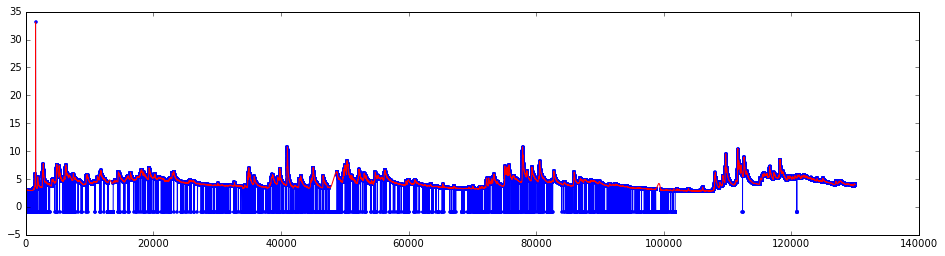

In [641]:
si = 14137000 # sorted(impurity)[-67]

Tm, Zm, Tc, Zc = get_data(db, si)

abs_thresh = np.median(Zm) + 15*np.subtract(*np.percentile(Zm, [90, 10]))
Zm[Zm <= 0] = -1
Zm[Zm > abs_thresh] = -1

Ym, Yc = align_measurements(Tm, Zm, Tc, Zc)  
Qm = fill_gaps(Ym, max_gap = 10000, spike_size = 2, window_size = 4*12)

plt.figure(figsize = (16,4))
plt.plot(Ym, 'b.-')
plt.plot(Qm, 'r-')
#plt.plot(Yc, 'r-')
#plt.ylim(2,5)
#plt.xlim(12800, 13000)

print(si)

In [345]:
n = 101
x = 2 + np.sin(np.linspace(0,2*np.pi,n)) + 0.1*np.random.randn(n)
#idx = np.random.choice(np.arange(n), 60, replace=False)
x[35:38] = -1
x[40:50] = -1
x[51:56] = -1
x[57:58] = -1
x[59:61] = -1
x[71:75] = -1
x[77:85] = -1

In [ ]:
[x_b - 3*x_2 + 3*x_1 - 1*x_a, 3*x_2 - 6*x_1 - 3*x_a, 3*x_1 - 3*x_a, 1*x_a - x[i]]

In [639]:
def solve_cubic(a, b, c, d):
    if a == 0 and b == 0:
        return (-d/c + 0j, -d/c + 0j, -d/c + 0j)
    
    D0 = b*b - 3*a*c
    D1 = 2*b*b*b - 9*a*b*c + 27*a*a*d
    D2 = D1*D1 - 4*D0*D0*D0
    D3 = np.sqrt(D2 + 0j)   
    D4 = D1 + D3 
    D5 = D4 if D4 != 0 else D1 - D3
    
    C = ( 0.5 * D5  + 0j) ** (1./3.)
    k = -0.5 - 0.8660254037844386j

    x = tuple([-(b + C*k**i + D0 / (C*k**i)) / (3*a) for i in range(3)])
    return x


def bezier_interpolator(x_a, y_a, dy_a, x_b, y_b, dy_b, x, eps = 1e-10):
    if x.size == 2:
        By = np.array([y_a, 0.5*(y_a + y_b)])
    
    else:
        # cubic bezier curve
        x_1 = x[x.size // 3]  
        x_2 = x[x.size - x.size // 3] 
        y_1 = y_a + dy_a*(x_1 - x_a)        
        y_2 = y_b + dy_b*(x_2 - x_b)        
        t = np.zeros(x.size)
        
        coef = np.array([x_b - 3*x_2 + 3*x_1 - 1*x_a, 
                               3*x_2 - 6*x_1 - 3*x_a, 
                                       3*x_1 - 3*x_a, 
                                               1*x_a])
        for i in range(x.size):
            coef[3] = x_a - x[i]
            #r = np.roots(coef)
            #idx = np.where(np.logical_and(r <= 1, r >= 0))[0][0]
            #t[i] = r[idx]
            r_0, r_1, r_2 = solve_cubic(coef[0], coef[1], coef[2], coef[3])
            if abs(r_0.imag) < eps and 0-eps <= r_0.real <= 1+eps:
                t[i] = r_0.real
            elif abs(r_1.imag) < eps and 0-eps <= r_1.real <= 1+eps:
                t[i] = r_1.real
            elif abs(r_2.imag) < eps and 0-eps <= r_2.real <= 1+eps:
                t[i] = r_2.real
            else:
                print(coef)
                raise Exception("Bezier interpolation: no real solution found.")
            
        By = (1-t)**3 * y_a + 3*t*(1-t)**2 * y_1 + 3*(1-t)*t**2 * y_2 + t**3 * y_b
        
    return By


def get_bisector(x, y, xl, yl, xr, yr):
    x1 = x - xl
    y1 = y - yl
    x1_n = np.sqrt(x1**2 + y1**2)

    x2 = xr - x
    y2 = yr - y
    x2_n = np.sqrt(x2**2 + y2**2)
    
    y3 = (y1 / x1_n + y2 / x2_n) / (x1 / x1_n + x2 / x2_n)
    return y3


def fill_gaps(y, max_gap = 10000, spike_size=2, window_size=10):
    z = y.copy()
    a = b = 0
    gap_size = 0

    for i in range(1, y.size):
        
        if y[i] > 0:
            a = b; b = i  # a, b are non-negative gap bounds          
            
            if b - a > 1 and gap_size < max_gap:                
                # left bounding condition
                j = 0
                while ( y[a - j] > 0 and a - j > 0 and j < window_size ) : 
                    j += 1

                if j <= spike_size:
                    p = 0
                    while ( y[a - j - p] < 0 and j + p < max_gap ) : p += 1
                    dy_a = get_bisector(a, y[a], a-j-p, y[a-j-p], b, y[b])                     
                else:
                    p = 0
                    dy_a = (y[a] - y[a-j+1]) / j  

                #right bounding condition
                k = 0
                while ( y[b + k] > 0 and b + k < y.size-1 and k < window_size ) : 
                    k += 1     
                
                if k <= spike_size:    
                    q = 0
                    while ( y[b + k + q] < 0 and k + q < max_gap ) : q += 1
                    dy_b = get_bisector(b, y[b], a, y[a], b + k + q, y[b + k + q])                     
                else:
                    q = 0
                    dy_b = (y[b+k-1] - y[b]) / k
                    
                z[a:b] = bezier_interpolator(0, y[a], dy_a, b-a, y[b], dy_b, np.arange(b-a))
                
            gap_size = 0
            
        else:
            gap_size += 1
                
    return np.array(z)

In [464]:
import line_profiler
%load_ext line_profiler
%load_ext Cython

In [680]:
%%cython -a
import cython
cimport numpy as np

cdef extern from "complex.h":
    complex I
    complex csqrt(complex z) nogil
    

cdef struct roots:
    complex r0
    complex r1
    complex r2


@cython.cdivision(True)
cdef roots solve_cubic_cth(float a, float b, float c, float d):
    cdef roots res
    if a == 0 and b == 0:
        res.r0 = <complex>(-d/c)
        res.r1 = <complex>(-d/c)
        res.r1 = <complex>(-d/c)
        return res
    
    cdef:
        double D0 = b*b - 3*a*c
        double D1 = 2*b*b*b - 9*a*b*c + 27*a*a*d
        double D2 = D1*D1 - 4*D0*D0*D0
        complex D3 = csqrt(D2)   
        complex D4 = D1 + D3 
        complex D5 = D4 if D4 != 0 else D1 - D3
    
        complex C = (0.5*D5) ** 0.3333333333333333
        complex k = -0.5 - 0.8660254037844386j # -1/2 - 1/2*np.sqrt(3)j
        
    # r_i = -(b + C*k**i + D0 / (C*k**i)) / (3*a)
    res.r0 = -(b + C + D0 / C) / (3*a)            # i = 0
    res.r1 = -(b + C*k + D0 / (C*k)) / (3*a)      # i = 1
    res.r2 = -(b + C*k*k + D0 / (C*k*k)) / (3*a)  # i = 2
    return res

In [640]:
%lprun -f bezier_interpolator fill_gaps(Ym, 1000, 2, 12*4)  

In [643]:
%lprun -f fill_gaps fill_gaps(Ym, max_gap = 10000, spike_size = 2, window_size = 4*12)

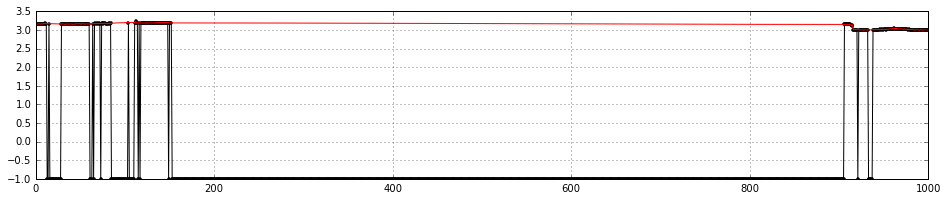

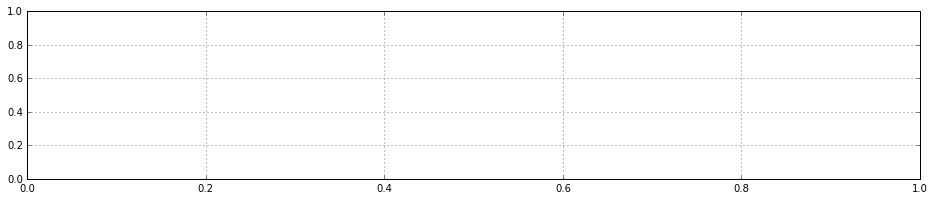

In [433]:
z = fill_gaps(x, 1000, 2, 5)       

plt.figure(figsize = (16,3))
plt.plot(x, 'k.-')
plt.plot(z, 'r-')
#plt.ylim(3,4.5)
#plt.xlim(70,160)
plt.grid()

plt.figure(figsize = (16,3))
#plt.plot(z[:,0], 'r.-')
#plt.plot(z[:,1], 'g.-')
#plt.plot(z[:,3], 'y.-')
plt.grid()